#### Editing log:
##### Orignal from 09/18/2022
##### Edited in 02/15/2023

In [20]:
import pandas as pd
from sklearn import linear_model 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
#from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score


In [48]:
# Define functions

def Filter_low_Expr(arr):
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg):
    array_list = []
    new_id_list = []
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            #cur_regulators_ids.append(dic_gene_map[i])

            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size):
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)

def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features): #modified at 11:46 AM Feb 15
    xgb_model = xgb.XGBClassifier(n_jobs=4)
    clf = GridSearchCV(xgb_model, {'max_depth': [2,3,4],
                                   'n_estimators': [100], 
                                   'learning_rate': [0.05, 0.1],
                                   #'gamma':[1],
                                   #'eta':[0.2,0.3,0.4],
                                  # 'min_child_weight':[1,2],
                                  # 'lambda':[1,2],
                                  # 'subsample':[0.8]
                                  }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=1, learning_rate = para['learning_rate'], max_depth=para['max_depth'], n_estimators=para['n_estimators'])
    xgb_model.fit(train_data,train_labels.values)
    #predictions = xgb_model.predict(test_data)
    
    predictions = clf.predict(test_data)
    
    predictions_independent = clf.predict(independent_features)
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))

    # Evaluate the accuracy of the XGBoost model
    accuracy = accuracy_score(test_labels, predictions)
    accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    #print("# Accuracy:  the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true")
    #print("Accuracy: ", accuracy)

    cm = confusion_matrix(  list(test_labels), predictions)
    sensitivity = cm[1,1]/(cm[1,0] + cm[1,1])
    precision = cm[1,1]/(cm[0,1] + cm[1,1])
    recall = recall_score(test_labels, predictions)
    #print("Recall: " + str(recall))
    #print("# Recall: TP / (TP + FN)")

    #print("confusion_matrix")
    #print(cm)

    #print("sensitivity: "+ str(sensitivity))

    #print("Precision: " + str(precision))
    #print("# Precision = TP / (TP + FP) ")
    f1 = f1_score(list(test_labels), predictions)
    f1_independent = f1_score(independent_labels, predictions_independent)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    result_summary = {}
    result_summary['random_state'] = random_
    result_summary['best_params'] = clf.best_params_
    result_summary['Accuracy'] = accuracy
    result_summary['ACC_independent'] = accuracy_independent

    result_summary['Precision'] = precision
    result_summary['sensitivity'] = sensitivity
    result_summary['F1_score'] = f1
    result_summary['F1_score_independent'] = f1_independent
    result_summary['features'] = result_feature
    return(result_summary)

In [3]:
# Load data
# Gene expression from BeatAML wave 1 and 2
Drug_data = pd.read_csv("../Data_resource/Drug_Response.csv",index_col = "Unnamed: 0") 
GE = pd.read_csv("../Data_resource/RPKM.csv",index_col = "Unnamed: 0")

#Load features from features that predict drug response, regulatory graph and house keeping genes
sele_house_keeping =  ["GPS2", "RPS10","ZNF91","FNTA","PSMC1","GPS1","MLH1","ARAF","SF3B2","PSMD2","SRP14","GNB1","HNRNPK","ARF1","RPS11"]
KG_expr_resp = pd.read_csv("KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_reg = pd.read_csv("KG_regulatory_graph.csv")


# Load testing data from BeatAML wave 3 and 4
BeatAML_wave_3_expr = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/rnaseq/beataml_waves1to4_allnorm.txt", sep = "\t") 
BeatAML_wave_3_drugResponse = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/inhibitor/beataml_probit_curve_fits_v4_distr_nonproprietary.txt", sep = "\t")

In [153]:
len(set(Drug_data['inhibitor']))

122

In [4]:
#Formating gene expression data for testing data
BeatAML_wave_3_expr.index = BeatAML_wave_3_expr['stable_id']
gene_list = (list(BeatAML_wave_3_expr.index))
sample_list = list(set(BeatAML_wave_3_expr.columns) - set(['stable_id','display_label','description','biotype']))
input_data_test = BeatAML_wave_3_expr.loc[list(gene_list), sample_list]

#Formating gene expression data for training data
GE.index = GE['Gene']
gene_list = (list(GE.index))
sample_list = list(set(GE.columns) - set(['Gene','Symbol']))
input_data = GE.loc[list(gene_list), sample_list]

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]


In [227]:
# Feature selection: Selection of first neighbors
#Drug = "JQ1"
Drug = "Trametinib (GSK1120212)"
#Drug = "Selumetinib (AZD6244)"
#Drug = "Venetoclax"
res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
res1 = res1.sort_values(by = ['coef'])
predictors = list(res1['Gene'])
predictors.remove(Drug+"_RSS")
predictors.remove(Drug+"_intercept")


In [228]:
# Selection of the second neighbors
#res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors[0:5] +  predictors[len(predictors)-5:len(predictors)])]
res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
res2 = res2.loc[res2['Coef'] <0]

In [229]:
selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
selected_genes.remove(Drug+"_RSS")
selected_genes.remove(Drug+"_intercept")
print(len(selected_genes))

51


In [230]:
print(selected_genes)

['AOC1', 'TBXAS1', 'RAB11FIP3', 'UQCC1', 'CA2', 'NDRG1', 'GLRX3', 'BLMH', 'CCND1', 'RALGPS2', 'RAB3GAP2', 'MED13L', 'FAM124B', 'SLC2A4RG', 'ARMCX1', 'ADCK2', 'GGACT', 'FHOD1', 'TNFRSF11A', 'ARHGAP18', 'LRRC3', 'SAFB', 'ZNF385A', 'SIGLEC16', 'ZNF75A', 'SLC22A15', 'NDRG2', 'TET2', 'GTSF1', 'ZNF274', 'GPHN', 'GATM', 'MYO1D', 'MROH1', 'LDOC1', 'PCBP3', 'FAM101B', 'CD300E', 'FAM221A', 'CTBP1-AS2', 'MT-CO2', 'LGR4', 'RP11-119F19.2', 'RPL41P1', 'AC079325.6', 'TPT1P9', 'DGUOK-AS1', 'CEBPA', 'RP11-317J10.2', 'RP11-439C15.4', 'U82695.10']


In [231]:
# Formating house keeping gene ids
sele_house_keeping_id = []
selected_genes_id = []

for g in selected_genes:
    selected_genes_id.append(dic_gene_map[g])
    
for g in sele_house_keeping:
    if g in dic_gene_map:
        sele_house_keeping_id.append(dic_gene_map[g])

In [232]:
new_feature_df_t = formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg)

new_feature_df_test = formating_relative_expression(input_data_test,selected_genes_id, sele_house_keeping_id, KG_reg)

In [233]:
new_feature_df_t

,AOC1-GPS2,AOC1-RPS10,AOC1-ZNF91,AOC1-FNTA,AOC1-PSMC1,AOC1-GPS1,AOC1-MLH1,AOC1-ARAF,AOC1-SF3B2,AOC1-PSMD2,...,RP11-439C15.4-MIR4461,RP11-439C15.4-MIR3191,RP11-439C15.4-MIR940,U82695.10-MIR621,U82695.10-MIR647,U82695.10-MIR570,U82695.10-MIR146A,U82695.10-MIR181A1HG,U82695.10-MIR374B,U82695.10-MIR5581
16-00351,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
14-00289,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15-00967,1,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
14-00376,1,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
14-00564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16-00073,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,1,1,1,0
16-00566,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
15-00974,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
13-00149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
# Formatting trainning data
Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
Drug_sele_df.index = Drug_sele_df['lab_id']
Drug_sele_df =Drug_sele_df.loc[:,['ic50']]

df_sele = pd.concat([new_feature_df_t, Drug_sele_df],axis = 1)
df_sele = df_sele.dropna()
df_sele.head(3)
df_sele.shape

(299, 1094)

In [235]:
df_sele

,AOC1-GPS2,AOC1-RPS10,AOC1-ZNF91,AOC1-FNTA,AOC1-PSMC1,AOC1-GPS1,AOC1-MLH1,AOC1-ARAF,AOC1-SF3B2,AOC1-PSMD2,...,RP11-439C15.4-MIR3191,RP11-439C15.4-MIR940,U82695.10-MIR621,U82695.10-MIR647,U82695.10-MIR570,U82695.10-MIR146A,U82695.10-MIR181A1HG,U82695.10-MIR374B,U82695.10-MIR5581,ic50
16-00351,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.035873
14-00289,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013717
15-00967,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.720663
14-00376,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.000000
16-01151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13-00118,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,10.000000
16-00073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.026781
15-00974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013717
13-00149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.000000


In [236]:
# Formatting testing data using beatAML wave 3/4

In [237]:
Drug_sele_df_wave3 = BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse['inhibitor'] == Drug]
Drug_sele_df_wave3.index = Drug_sele_df_wave3['lab_id']
Drug_sele_df_wave3 =Drug_sele_df_wave3.loc[:,['ic50']]

df_sele__wave3 = pd.concat([new_feature_df_test, Drug_sele_df_wave3],axis = 1)
df_sele__wave3 = df_sele__wave3.dropna()
df_sele__wave3.head(3)
df_sele__wave3.shape


(484, 1094)

In [238]:
df_sele__wave3_new = df_sele__wave3.loc[(set(df_sele__wave3.index)-set(df_sele.index)),:]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_24009/1949196757.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_sele__wave3_new = df_sele__wave3.loc[(set(df_sele__wave3.index)-set(df_sele.index)),:]


In [239]:
df_sele__wave3_new.shape

(185, 1094)

In [240]:
df_sele__wave3_cur

,CLASP1-GPS2,CLASP1-RPS10,CLASP1-ZNF91,CLASP1-FNTA,CLASP1-PSMC1,CLASP1-GPS1,CLASP1-MLH1,CLASP1-ARAF,CLASP1-SF3B2,CLASP1-PSMD2,...,ZSCAN16-AS1-MIR4312,RP11-355B11.2-MIR378I,RP11-355B11.2-MIR4746,RP11-355B11.2-MIR4519,RP11-355B11.2-MIR1254-1,CASC15-KLF4,CASC15-MIR371B,CASC15-MIR4435-1HG,ic50,Venetoclax_bi
17-00423,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,7.766565,0
17-00113,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.045302,1
18-00223,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,10.000000,0
17-01054,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.013700,1
17-00641,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.013700,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17-00770,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.676486,1
17-00463,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.013700,1
18-00048,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078336,1
17-00536,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.242148,0


In [241]:
#Drug = "Venetoclax"

result_with_threshod = {}
for Threshod in [0.2,0.5,1]:
    data_cur = df_sele # Step 1
    data_cur = data_cur.dropna()
    new_label = []
    for i in data_cur['ic50'].values:
        if i <= Threshod:
            new_label.append(1)
        else:
            new_label.append(0)
    data_cur[Drug+"_bi"] = new_label
    
    df_sele__wave3_cur = df_sele__wave3_new
    new_label = []
    for i in df_sele__wave3_cur['ic50']:
        if i <= Threshod:
            new_label.append(1)
        else:
            new_label.append(0)
    df_sele__wave3_cur[Drug+"_bi"] = new_label

    result_all = {}
    result_all_test_w3 = {}
    for random_ in range(0,200,5): 
        sensitive_data = data_cur.loc[data_cur[Drug+"_bi"] == 1]
        resistant_data = data_cur.loc[data_cur[Drug+"_bi"] == 0]

        train_data_sen, test_data_sen, train_labels_sen, test_labels_sen = train_test_split(sensitive_data.iloc[:,:-2], 
                                                                            sensitive_data.iloc[:,-1],
                                                                            test_size = 0.2, random_state = random_)
        train_data_res, test_data_res, train_labels_res, test_labels_res = train_test_split(resistant_data.iloc[:,:-2], 
                                                                            resistant_data.iloc[:,-1],
                                                                            test_size = 0.2, random_state = random_)

        train_data = pd.concat([train_data_sen, train_data_res])
        test_data = pd.concat([test_data_sen, test_data_res])
        train_labels = pd.concat([train_labels_sen, train_labels_res])
        test_labels = pd.concat([test_labels_sen, test_labels_res])
        
        test_w3_labels = df_sele__wave3_cur[Drug+"_bi"]
        test_w3_features = df_sele__wave3_cur.iloc[:,:-2]
        
        result_all[random_] = model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, df_sele__wave3_cur[Drug+"_bi"],  df_sele__wave3_cur.iloc[:,:-2])
        
    result_with_threshod[Threshod] = result_all


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates

In [242]:
result_with_threshod

{0.2: {0: {'random_state': 0,
   'best_params': {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100},
   'Accuracy': 0.75,
   'ACC_independent': 0.6810810810810811,
   'Precision': 0.75,
   'sensitivity': 0.8571428571428571,
   'F1_score': 0.7999999999999999,
   'F1_score_independent': 0.7330316742081447,
   'features':                 Feature       IMP
   336        ZNF385A-MLH1  0.034045
   894      GGACT-MIR503HG  0.023321
   981        MYO1D-POU2F2  0.020090
   1056  AC079325.6-MIR628  0.017183
   69            CA2-PSMD2  0.016087
   ...                 ...       ...
   240          GGACT-GPS2  0.000508
   261          FHOD1-MLH1  0.000399
   214        ARMCX1-PSMC1  0.000272
   468           GATM-FNTA  0.000253
   202       SLC2A4RG-ARAF  0.000181
   
   [194 rows x 2 columns]},
  5: {'random_state': 5,
   'best_params': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100},
   'Accuracy': 0.7333333333333333,
   'ACC_independent': 0.6918918918918919,
   'Precision': 

In [243]:
Value_list = []
Type_list = []
Threshold_list = []
ACC_list = []
ACC_independent_test_list = []
F1_list = []
F1_independent_test_list = []

for Threshod in  result_with_threshod:
    for random_state in result_with_threshod[Threshod]:
        if "Accuracy" in result_with_threshod[Threshod][random_state]:
            ACC_list.append(result_with_threshod[Threshod][random_state]['Accuracy'])
        if "ACC_independent" in result_with_threshod[Threshod][random_state]:
            ACC_independent_test_list.append(result_with_threshod[Threshod][random_state]['ACC_independent'])
        if "F1_score" in result_with_threshod[Threshod][random_state]:
            F1_list.append(result_with_threshod[Threshod][random_state]['F1_score'])
        if "F1_score_independent" in result_with_threshod[Threshod][random_state]:
            F1_independent_test_list.append(result_with_threshod[Threshod][random_state]['F1_score_independent'])

        Threshold_list.append(Threshod)


Text(0, 0.5, 'ACC (BeatAML W3/4)')

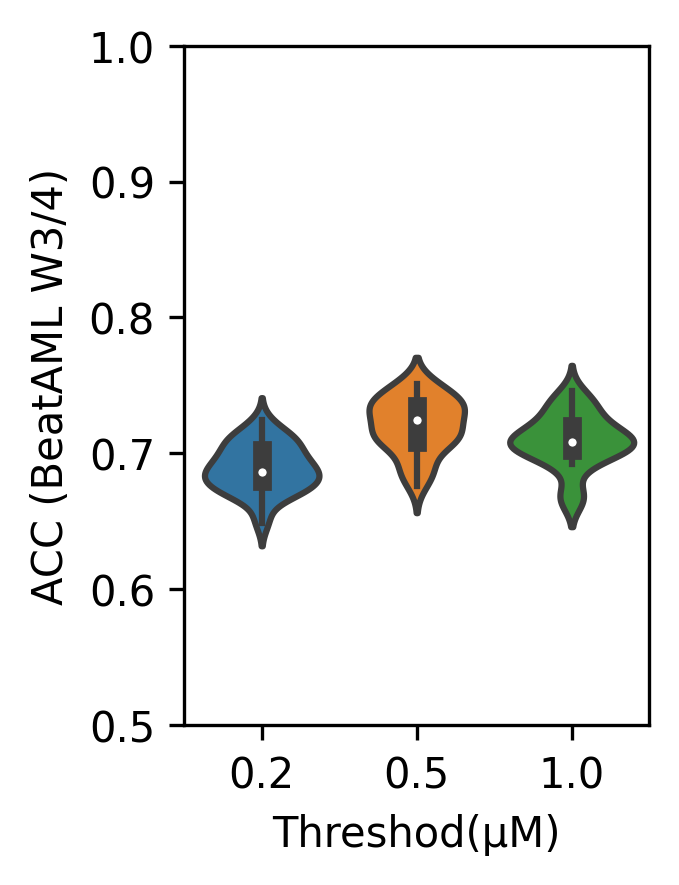

In [244]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
acc_df=pd.DataFrame({"Threshod(μM)":Threshold_list, "ACC":ACC_independent_test_list})
sns.violinplot(data=pd.DataFrame({"Threshod(μM)":Threshold_list, "ACC_w3":ACC_independent_test_list}), x="Threshod(μM)", y="ACC_w3")
plt.ylim(0.5,1)
plt.ylabel("ACC (BeatAML W3/4)")

0.7809961869261153


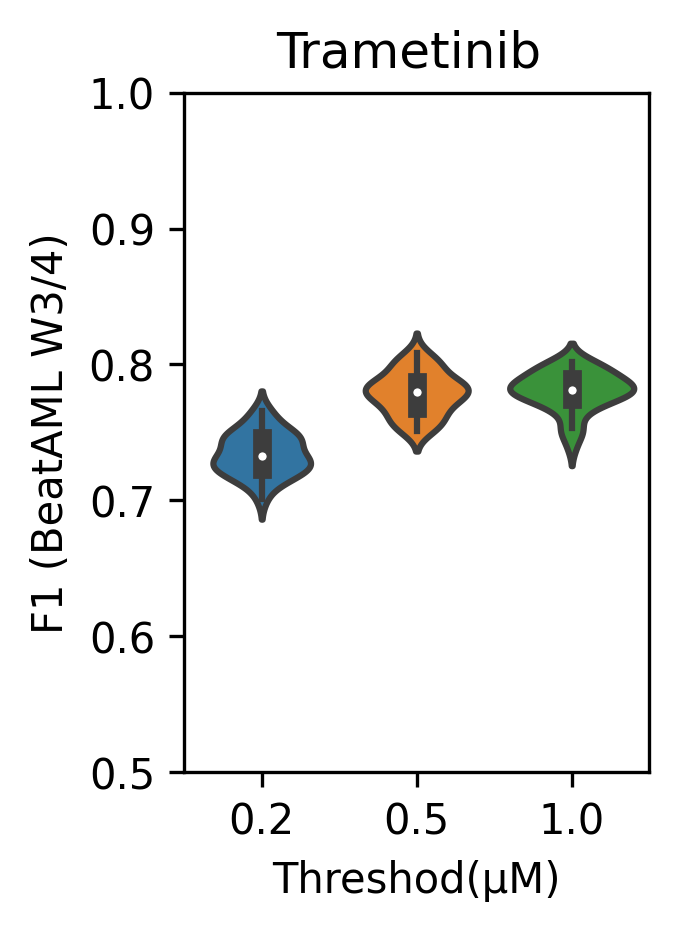

In [252]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
r = pd.DataFrame({"Threshod(μM)":Threshold_list, "F1_w3":F1_independent_test_list})
sns.violinplot(data=pd.DataFrame({"Threshod(μM)":Threshold_list, "F1_w3":F1_independent_test_list}),
               x="Threshod(μM)", y="F1_w3"
              )
plt.ylim(0.5,1)
plt.ylabel("F1 (BeatAML W3/4)")
plt.title(Drug.split("(")[0])
print(np.median(r.loc[r['Threshod(μM)'] == 1]['F1_w3']))

([<matplotlib.axis.XTick at 0x146602560>,
 [Text(0, 0, 'AC079325.6-MIR628'),
  Text(1, 0, 'ARHGAP18-CEBPA'),
  Text(2, 0, 'SLC22A15-PSMC1'),
  Text(3, 0, 'PCBP3-FNTA'),
  Text(4, 0, 'ARHGAP18-FNTA'),
  Text(5, 0, 'CD300E-GPS2'),
  Text(6, 0, 'GPHN-MIR155HG'),
  Text(7, 0, 'CD300E-NKX3-1'),
  Text(8, 0, 'RPL41P1-PSMD2'),
  Text(9, 0, 'CA2-PSMD2'),
  Text(10, 0, 'SIGLEC16-MIR4772'),
  Text(11, 0, 'CA2-GNB1'),
  Text(12, 0, 'AC079325.6-RPS10'),
  Text(13, 0, 'AOC1-MIR155HG'),
  Text(14, 0, 'AOC1-ZNF418'),
  Text(15, 0, 'RP11-317J10.2-MIR4453'),
  Text(16, 0, 'NDRG1-PSMD2'),
  Text(17, 0, 'TBXAS1-MLH1'),
  Text(18, 0, 'NDRG1-SMARCA5'),
  Text(19, 0, 'U82695.10-MIR570')])

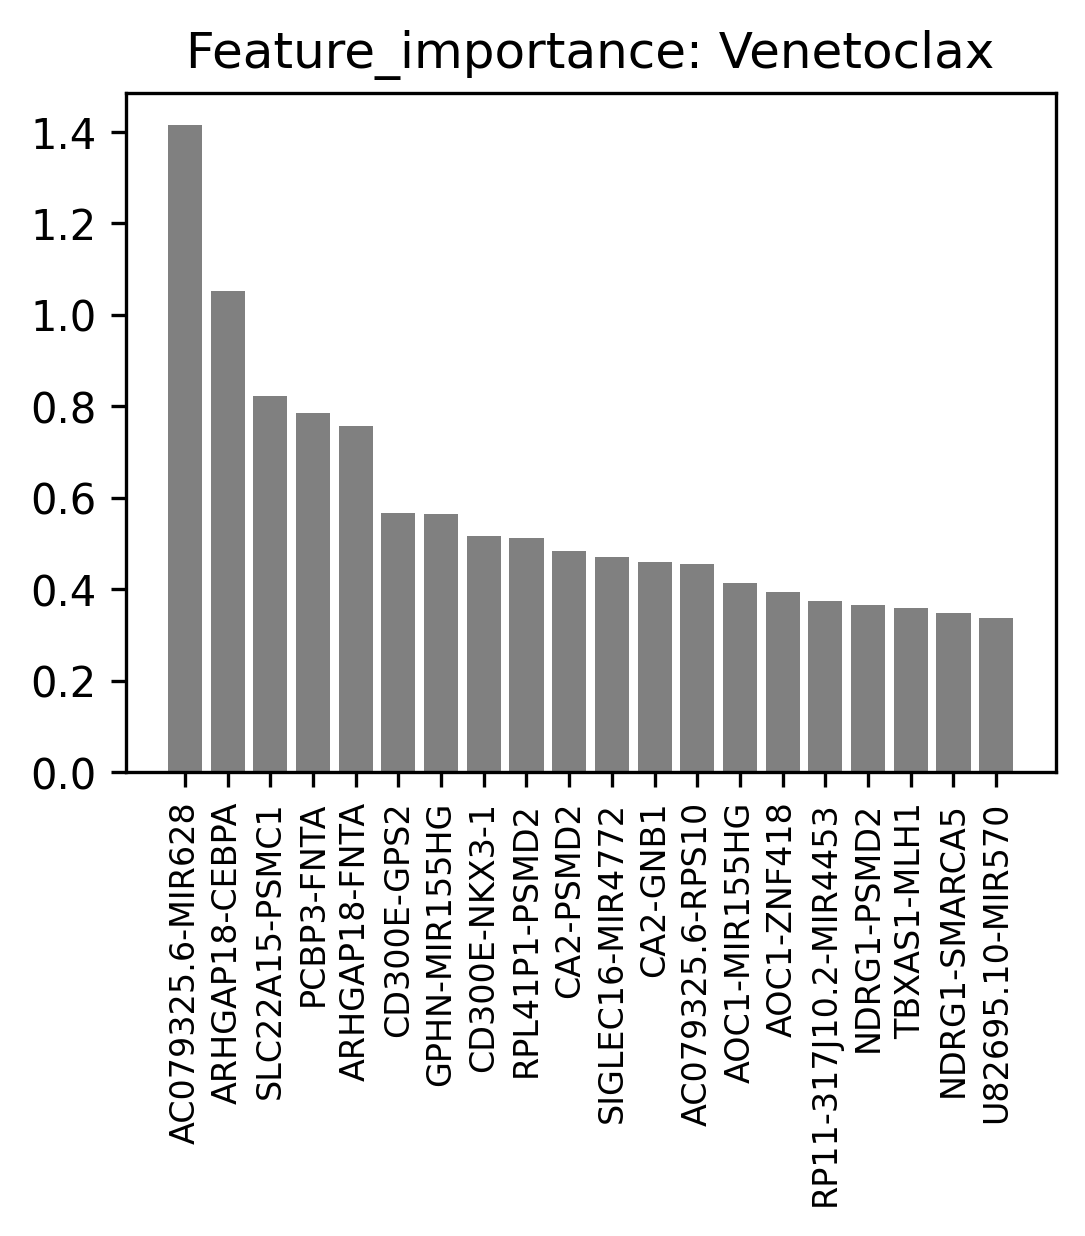

In [246]:
# Plot top important features 
feature_IMP =pd.DataFrame()
Threshold = 1
for random_state in result_with_threshod[Threshold]:
    features = result_with_threshod[Threshold][random_state]['features']['Feature'].values
    IMP = result_with_threshod[Threshold][random_state]['features']['IMP'].values
    cur_df = pd.DataFrame({"IMP" + str(random_state): IMP})
    cur_df.index = features
    feature_IMP = pd.concat([feature_IMP,cur_df ],axis =1)
    
IMP_sum = feature_IMP.transpose().sum()
x_feature = pd.DataFrame({"Feature":IMP_sum.index, "IMP":IMP_sum.values})
x_feature_sorted = x_feature.sort_values(by = ["IMP"], ascending = False).head(20)

plt.figure(figsize = (4,3),dpi = 300)
plt.title("Feature_importance: " + "Venetoclax")
plt.bar(np.arange(0,x_feature_sorted.shape[0], 1), x_feature_sorted['IMP'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
#plt.ylabel("correlation coeffient")
plt.xticks(np.arange(0,x_feature_sorted.shape[0], 1),x_feature_sorted['Feature'] , rotation = 90, fontsize =8)


([<matplotlib.axis.XTick at 0x146696170>,
 [Text(0, 0, 'AC079325.6-MIR628'),
  Text(1, 0, 'ARHGAP18-CEBPA'),
  Text(2, 0, 'SLC22A15-PSMC1'),
  Text(3, 0, 'PCBP3-FNTA'),
  Text(4, 0, 'ARHGAP18-FNTA'),
  Text(5, 0, 'CD300E-GPS2'),
  Text(6, 0, 'GPHN-MIR155HG'),
  Text(7, 0, 'CD300E-NKX3-1'),
  Text(8, 0, 'RPL41P1-PSMD2'),
  Text(9, 0, 'CA2-PSMD2'),
  Text(10, 0, 'SIGLEC16-MIR4772'),
  Text(11, 0, 'CA2-GNB1'),
  Text(12, 0, 'AC079325.6-RPS10'),
  Text(13, 0, 'AOC1-MIR155HG'),
  Text(14, 0, 'AOC1-ZNF418'),
  Text(15, 0, 'RP11-317J10.2-MIR4453'),
  Text(16, 0, 'NDRG1-PSMD2'),
  Text(17, 0, 'TBXAS1-MLH1'),
  Text(18, 0, 'NDRG1-SMARCA5'),
  Text(19, 0, 'U82695.10-MIR570')])

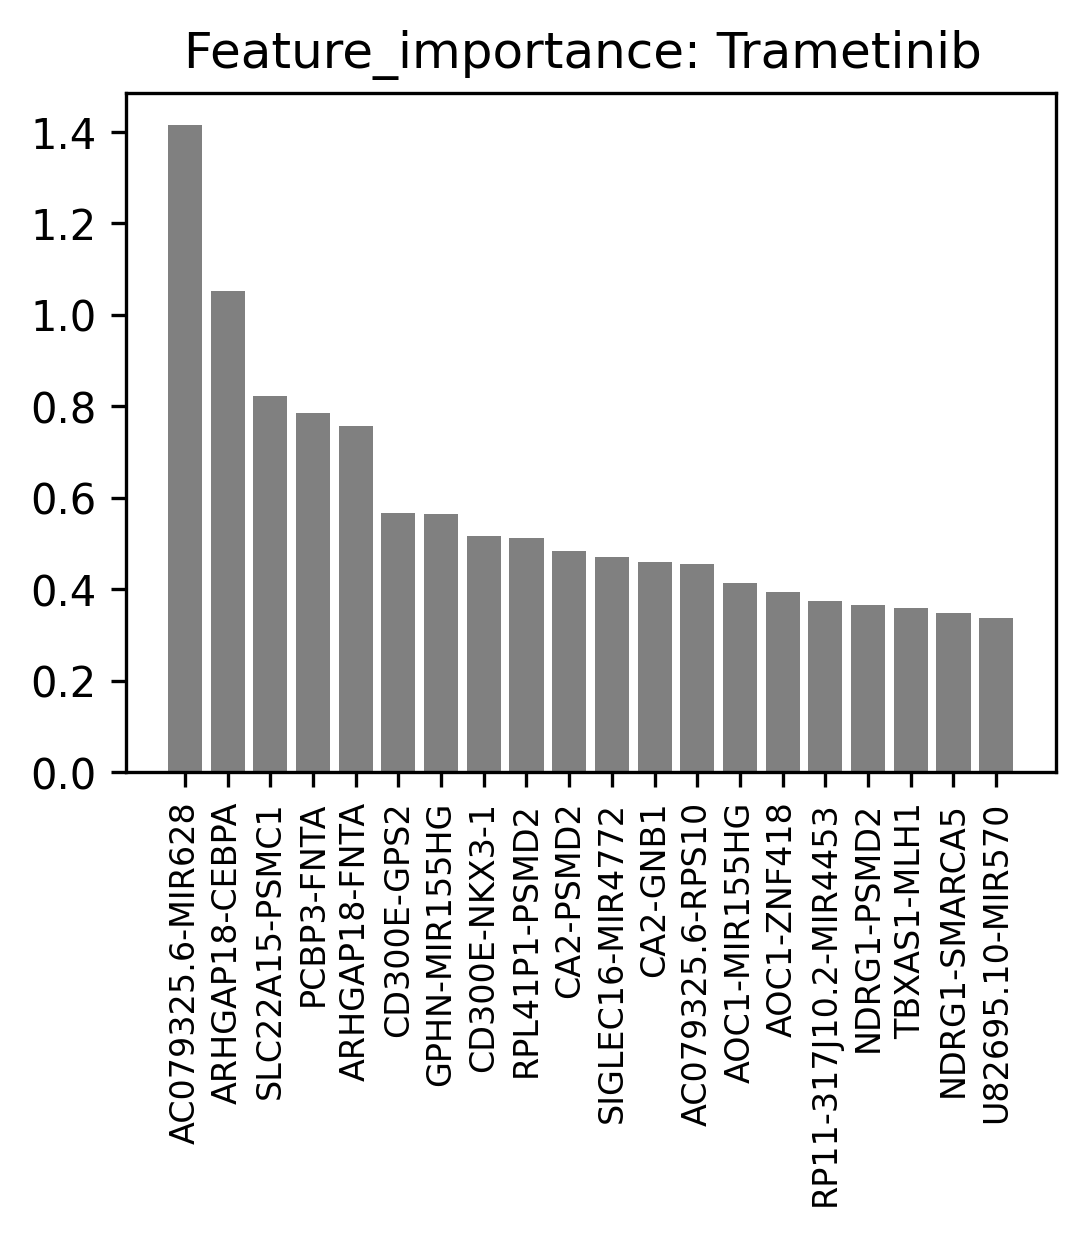

In [247]:
plt.figure(figsize = (4,3),dpi = 300)
plt.title("Feature_importance: " + Drug.split("(")[0])
plt.bar(np.arange(0,x_feature_sorted.shape[0], 1), x_feature_sorted['IMP'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
#plt.ylabel("correlation coeffient")
plt.xticks(np.arange(0,x_feature_sorted.shape[0], 1),x_feature_sorted['Feature'] , rotation = 90, fontsize =8)


0.7868852459016393


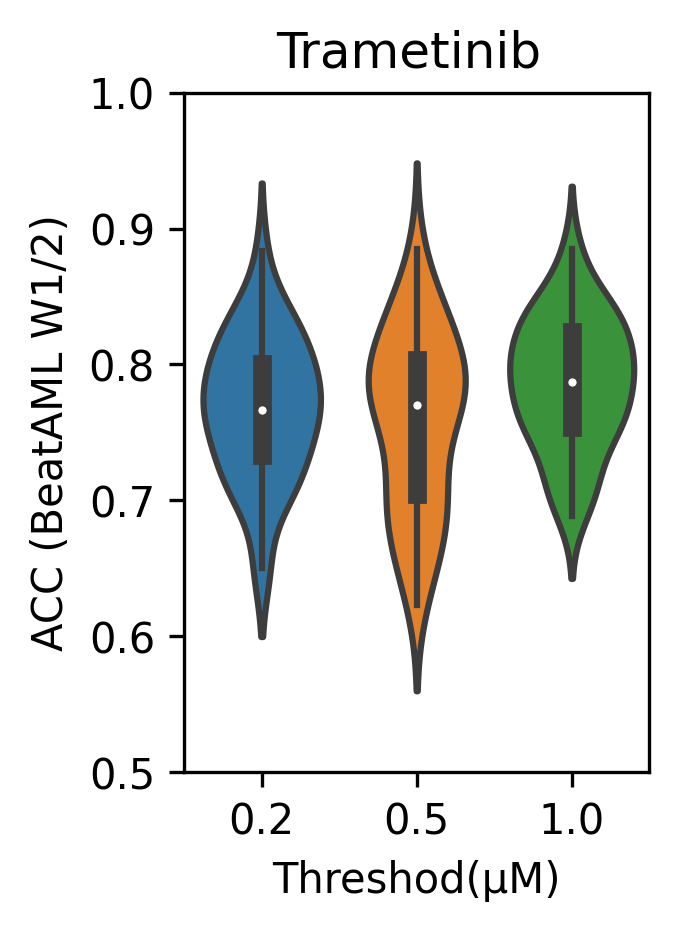

In [248]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
acc_df=pd.DataFrame({"Threshod(μM)":Threshold_list, "ACC":ACC_list})
sns.violinplot(data=pd.DataFrame({"Threshod(μM)":Threshold_list, "ACC":ACC_list}), x="Threshod(μM)", y="ACC")
plt.ylim(0.5,1)
plt.ylabel("ACC (BeatAML W1/2)")
plt.title(Drug.split("(")[0])
print(np.median(acc_df.loc[acc_df['Threshod(μM)'] == 1]['ACC']))

0.8408057179987005


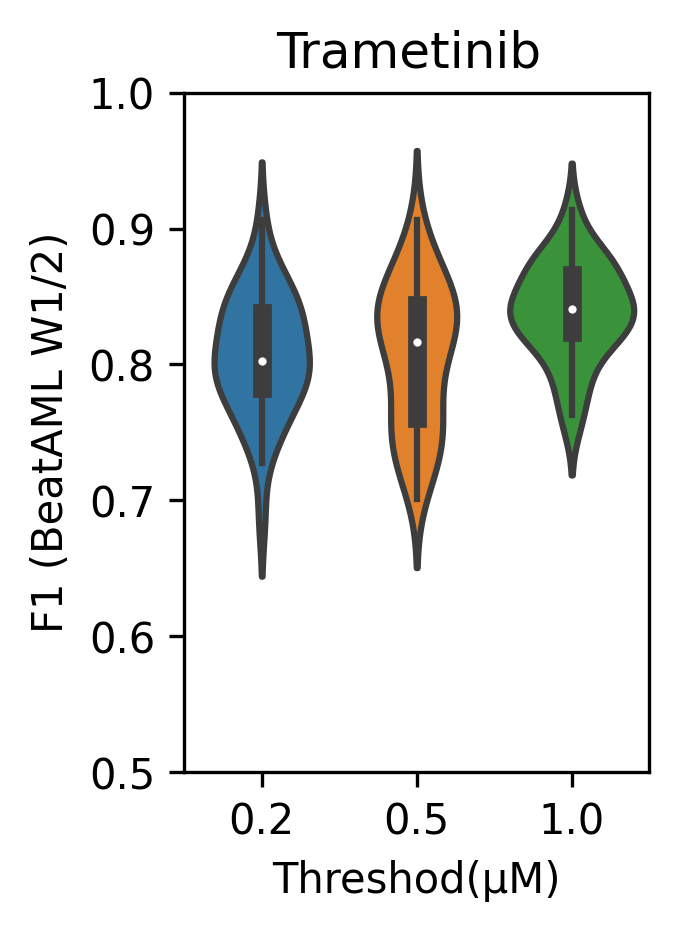

In [251]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
f1_df = pd.DataFrame({"Threshod(μM)":Threshold_list, "F1_score":F1_list})
sns.violinplot(data=f1_df, x="Threshod(μM)", y="F1_score")
#plt.title("Validation Set")
plt.ylim(0.5,1)
plt.ylabel("F1 (BeatAML W1/2)")
plt.title(Drug.split("(")[0])

print(np.median(f1_df.loc[acc_df['Threshod(μM)'] == 1]['F1_score']))

In [250]:
print(np.median(f1_df.loc[f1_df['Threshod(μM)'] == 1]['F1_score']))
print(np.median(acc_df.loc[acc_df['Threshod(μM)'] == 1]['ACC']))


0.8408057179987005
0.7868852459016393
